In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno

from sklearn import linear_model
from sklearn.model_selection import train_test_split
import pickle

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

In [2]:
df = pd.read_csv('../../data/raw/triathlon_watch_training_data_final.csv')
#count missing values
df.isnull().sum()


ID                               22
Age of customer                  22
Sex                              22
Ctry                             22
Town                             61
Swimming Hours per Week          22
Biking Hours per Week            46
Running Hours per Week           22
Total Training Hours per Week    22
VO2 Max                          25
10k Running Time Prediction      22
Calories Burned per Week         41
Support Cases of Customer        22
Customer Years                   22
Most current software update     23
Goal of Training                 50
Preferred Training Daytime       46
Subscription Type                23
Color of Watch                   54
Synchronisation                  50
User of latest model             22
dtype: int64

In [3]:
# Rename columns
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

In [4]:
num_empty_rows = df.isnull().all(axis=1).sum()
print(f"Anzahl der komplett leeren Zeilen: {num_empty_rows}")

Anzahl der komplett leeren Zeilen: 21


In [5]:
#liste aller Spalten, die als Object definiert sind und möglicherweise als Kategorial einzustufen sind
category_columns = list(df.describe(include='object').columns)
category_columns.remove('id')
category_columns.remove('most_current_software_update')
category_columns.remove('synchronisation')
date_columns = ['most_current_software_update']
bool_columns = ['synchronisation']
target_columns = ['user_of_latest_model']
#Numerische Spalten identifizieren und Zielspalten entfernen
numeric_columns = df.describe().columns
numeric_columns = [x for x in numeric_columns if x not in target_columns]
text_columns = ['id']
#Übersicht aller Spaltengruppen ausgeben
print("Category Columns:", category_columns)
print("Date Columns:", date_columns)
print("Boolean Columns:", bool_columns)
print("Numeric Columns:", numeric_columns)
print("Text Columns:", text_columns)
print("Target Columns:", target_columns)

#Boolesche Spalten umwandeln in numerische Variable
for bool_column in bool_columns:
    df[bool_column] = df[bool_column].map({'Yes': 1, 'No': 0})

Category Columns: ['sex', 'ctry', 'town', 'goal_of_training', 'preferred_training_daytime', 'subscription_type', 'color_of_watch']
Date Columns: ['most_current_software_update']
Boolean Columns: ['synchronisation']
Numeric Columns: ['age_of_customer', 'swimming_hours_per_week', 'biking_hours_per_week', 'running_hours_per_week', 'total_training_hours_per_week', 'vo2_max', '10k_running_time_prediction', 'calories_burned_per_week', 'support_cases_of_customer', 'customer_years']
Text Columns: ['id']
Target Columns: ['user_of_latest_model']


<bound method DataFrame.info of         id  age_of_customer     sex       ctry        town  \
0    C0001             61.0   Other         UK  Birmingham   
1    C0003             57.0   Other  Australia      Sydney   
2    C0004             30.0   Other      India   Bangalore   
3    C0005             21.0    Male    Germany      Munich   
4    C0006             63.0    Male      India      Mumbai   
..     ...              ...     ...        ...         ...   
995  C0996             28.0  Female  Australia    Brisbane   
996  C0997             54.0  Female  Australia   Melbourne   
997  C0998             35.0   Other        USA    New York   
998  C0999             31.0   Other    Germayn      Berlin   
999  C1000             27.0    Male      India      Mumbai   

     swimming_hours_per_week  biking_hours_per_week  running_hours_per_week  \
0                       2.52                   0.10                    1.78   
1                       1.55                  10.01              

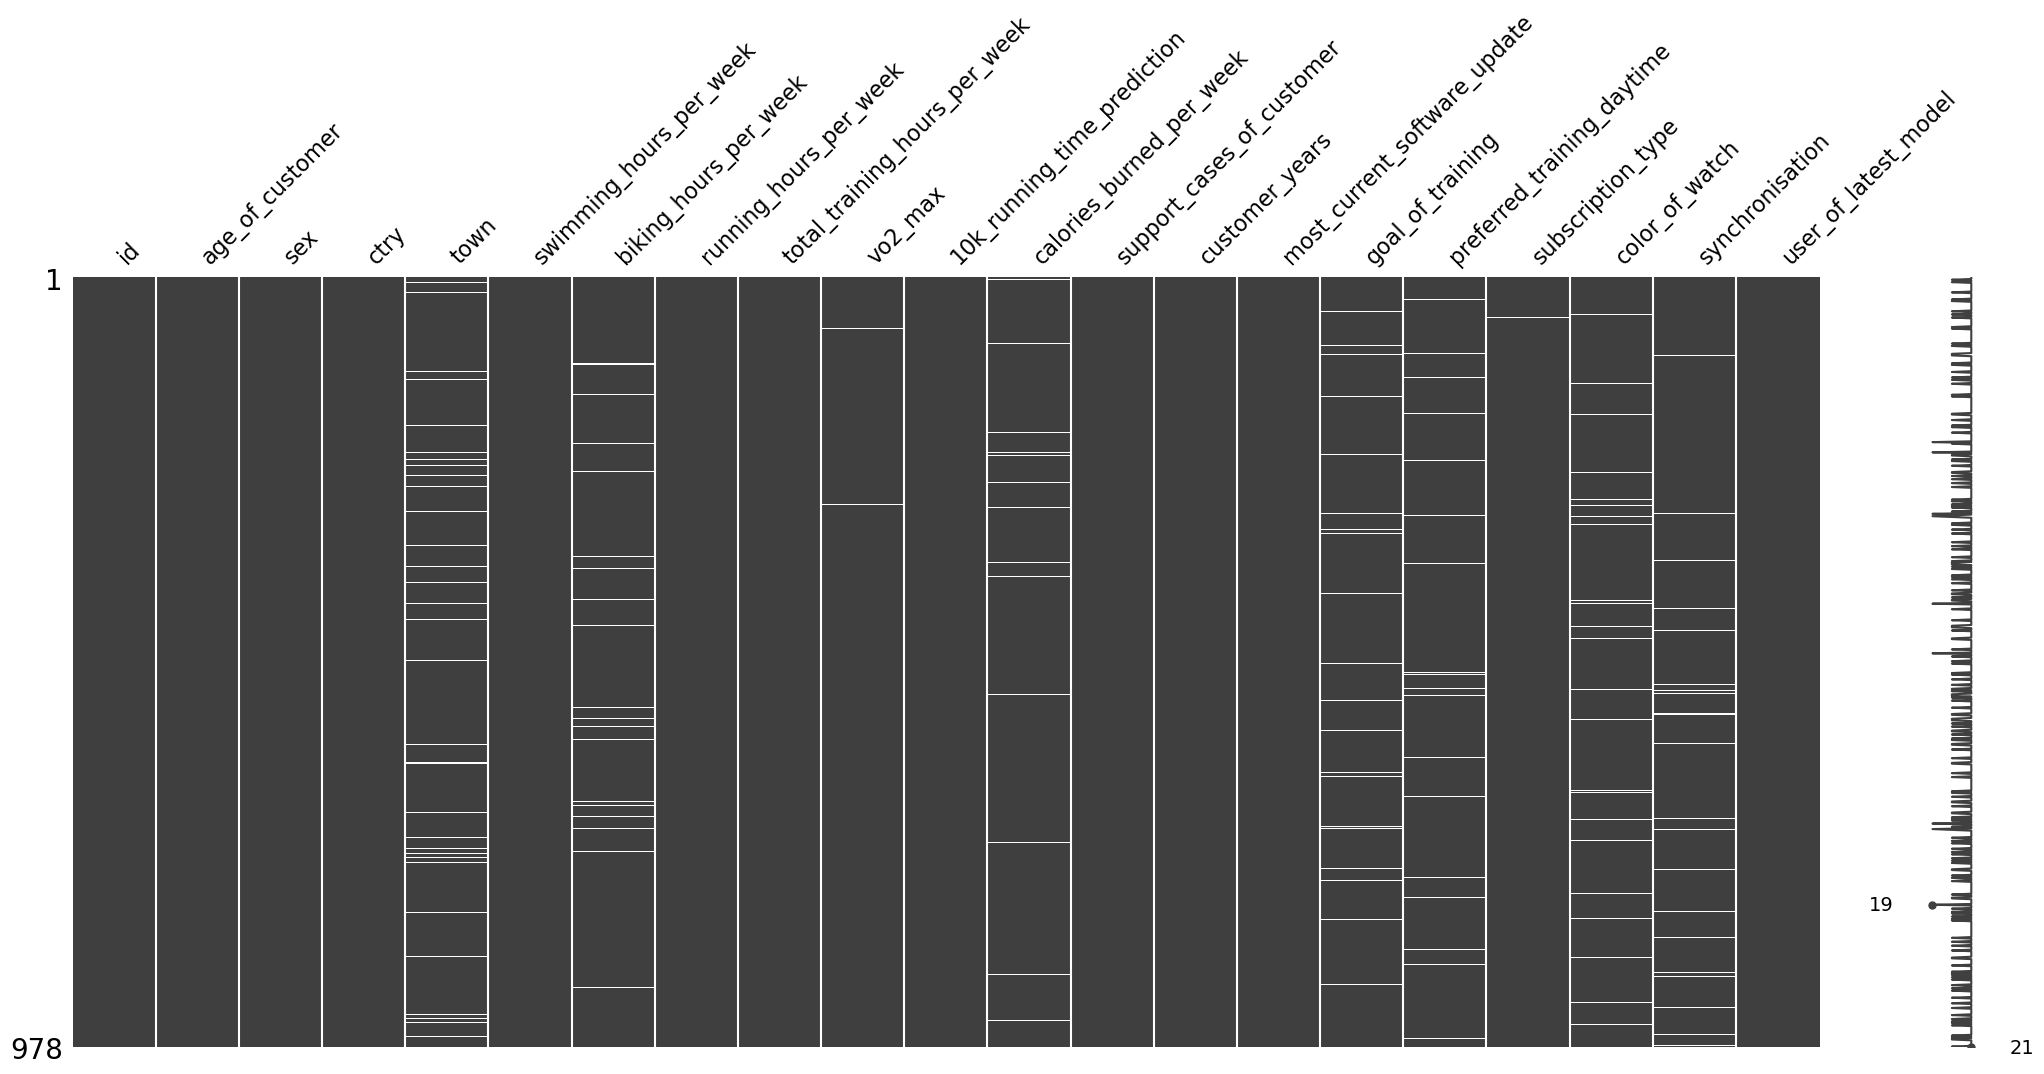

In [6]:
# Missing Value Handling - Deletion of entries with missing values in the target colunm
df=df.drop(df[df[target_columns[0]].isnull()].index)
msno.matrix(df)
df.info

In [7]:
df.filter(numeric_columns).describe()

,age_of_customer,swimming_hours_per_week,biking_hours_per_week,running_hours_per_week,total_training_hours_per_week,vo2_max,10k_running_time_prediction,calories_burned_per_week,support_cases_of_customer,customer_years
count,978.000000,978.000000,954.000000,978.000000,978.000000,974.000000,978.000000,959.000000,978.000000,978.000000
mean,40.529652,2.226196,5.529109,3.262219,11.446155,51.172954,45.610521,5487.534849,1.956033,3.792434
std,14.072180,1.595254,3.499372,2.165709,8.038531,20.530249,7.549771,2499.741648,1.413167,2.916593
min,-1.000000,0.000000,0.000000,0.000000,0.150000,10.220000,29.120000,-47.260000,0.000000,0.000000
25%,29.000000,1.020000,2.767500,1.635000,7.380000,42.065000,40.302500,3661.940000,1.000000,1.000000
50%,41.000000,2.020000,5.110000,2.930000,10.220000,53.400000,43.885000,5168.410000,2.000000,3.000000
75%,53.000000,3.187500,7.870000,4.600000,14.097500,60.065000,50.257500,7000.840000,3.000000,6.000000
max,64.000000,9.970000,16.110000,11.870000,100.000000,247.257800,67.060000,13280.060000,4.000000,11.000000


array([[<Axes: title={'center': 'age_of_customer'}>,
        <Axes: title={'center': 'swimming_hours_per_week'}>,
        <Axes: title={'center': 'biking_hours_per_week'}>],
       [<Axes: title={'center': 'running_hours_per_week'}>,
        <Axes: title={'center': 'total_training_hours_per_week'}>,
        <Axes: title={'center': 'vo2_max'}>],
       [<Axes: title={'center': '10k_running_time_prediction'}>,
        <Axes: title={'center': 'calories_burned_per_week'}>,
        <Axes: title={'center': 'support_cases_of_customer'}>],
       [<Axes: title={'center': 'customer_years'}>,
        <Axes: title={'center': 'synchronisation'}>,
        <Axes: title={'center': 'user_of_latest_model'}>]], dtype=object)

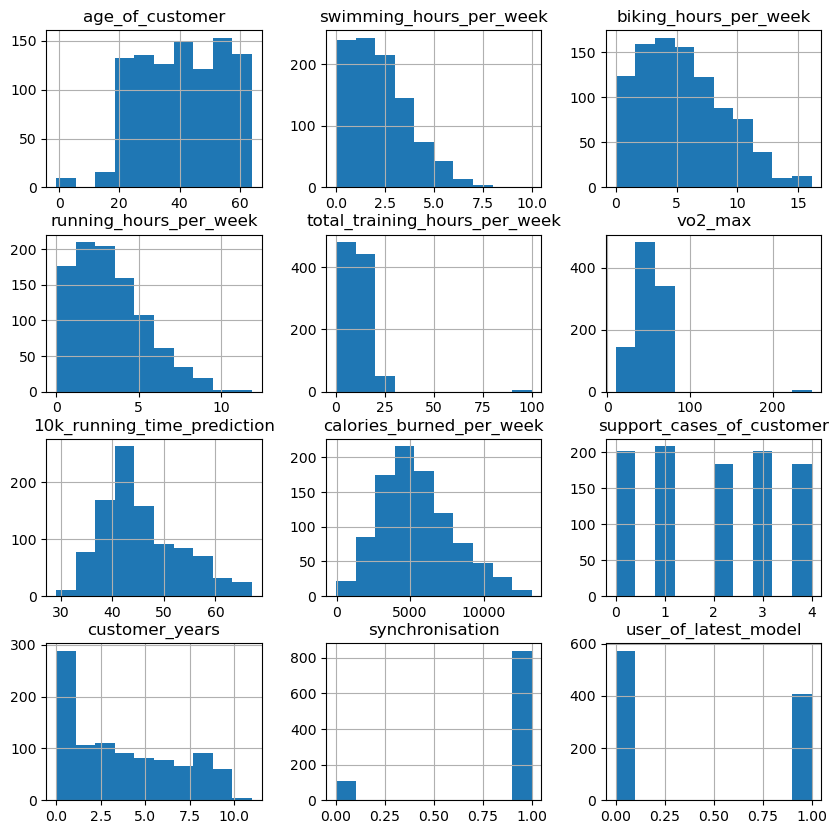

In [8]:
df.hist(figsize=(10,10))

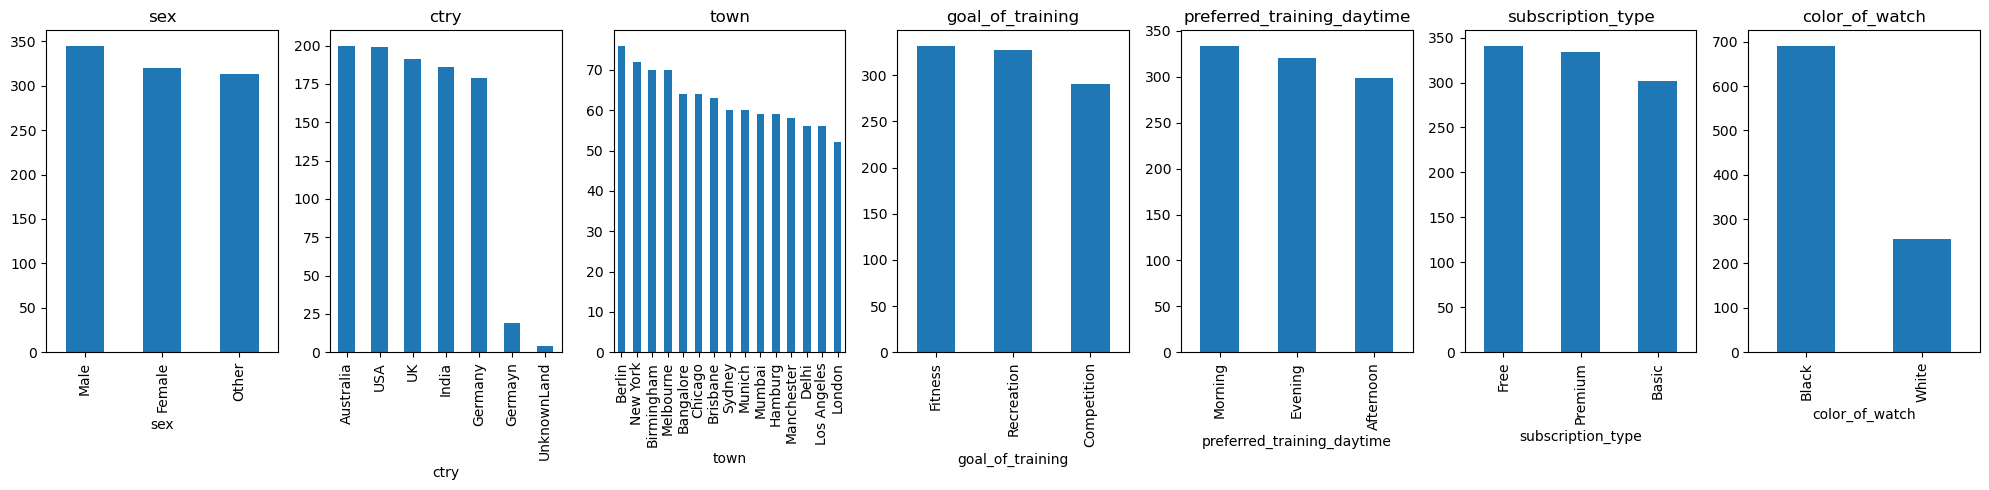

In [9]:
# Verteilung der kategorischen Variablen anzeigen
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, len(category_columns), figsize=(20, 5))
for col in category_columns:
    df[col].value_counts().plot(kind='bar', ax=ax[category_columns.index(col)], title=col)
fig.tight_layout()


In [10]:
df.describe(include='object')

,id,sex,ctry,town,most_current_software_update,goal_of_training,preferred_training_daytime,subscription_type,color_of_watch
count,978,978,978,939,977,950,954,977,946
unique,971,3,7,15,393,3,3,3,2
top,C0708,Male,Australia,Berlin,2023-12-08,Fitness,Morning,Free,Black
freq,2,345,200,76,9,332,334,341,691


In [11]:
## Check Countries distribution
df['ctry'].value_counts()

ctry
Australia      200
USA            199
UK             191
India          186
Germany        179
Germayn         19
UnknownLand      4
Name: count, dtype: int64

In [12]:
#Germayn in Germany wandeln
df['ctry'] = df['ctry'].replace('Germayn', 'Germany')

<Axes: >

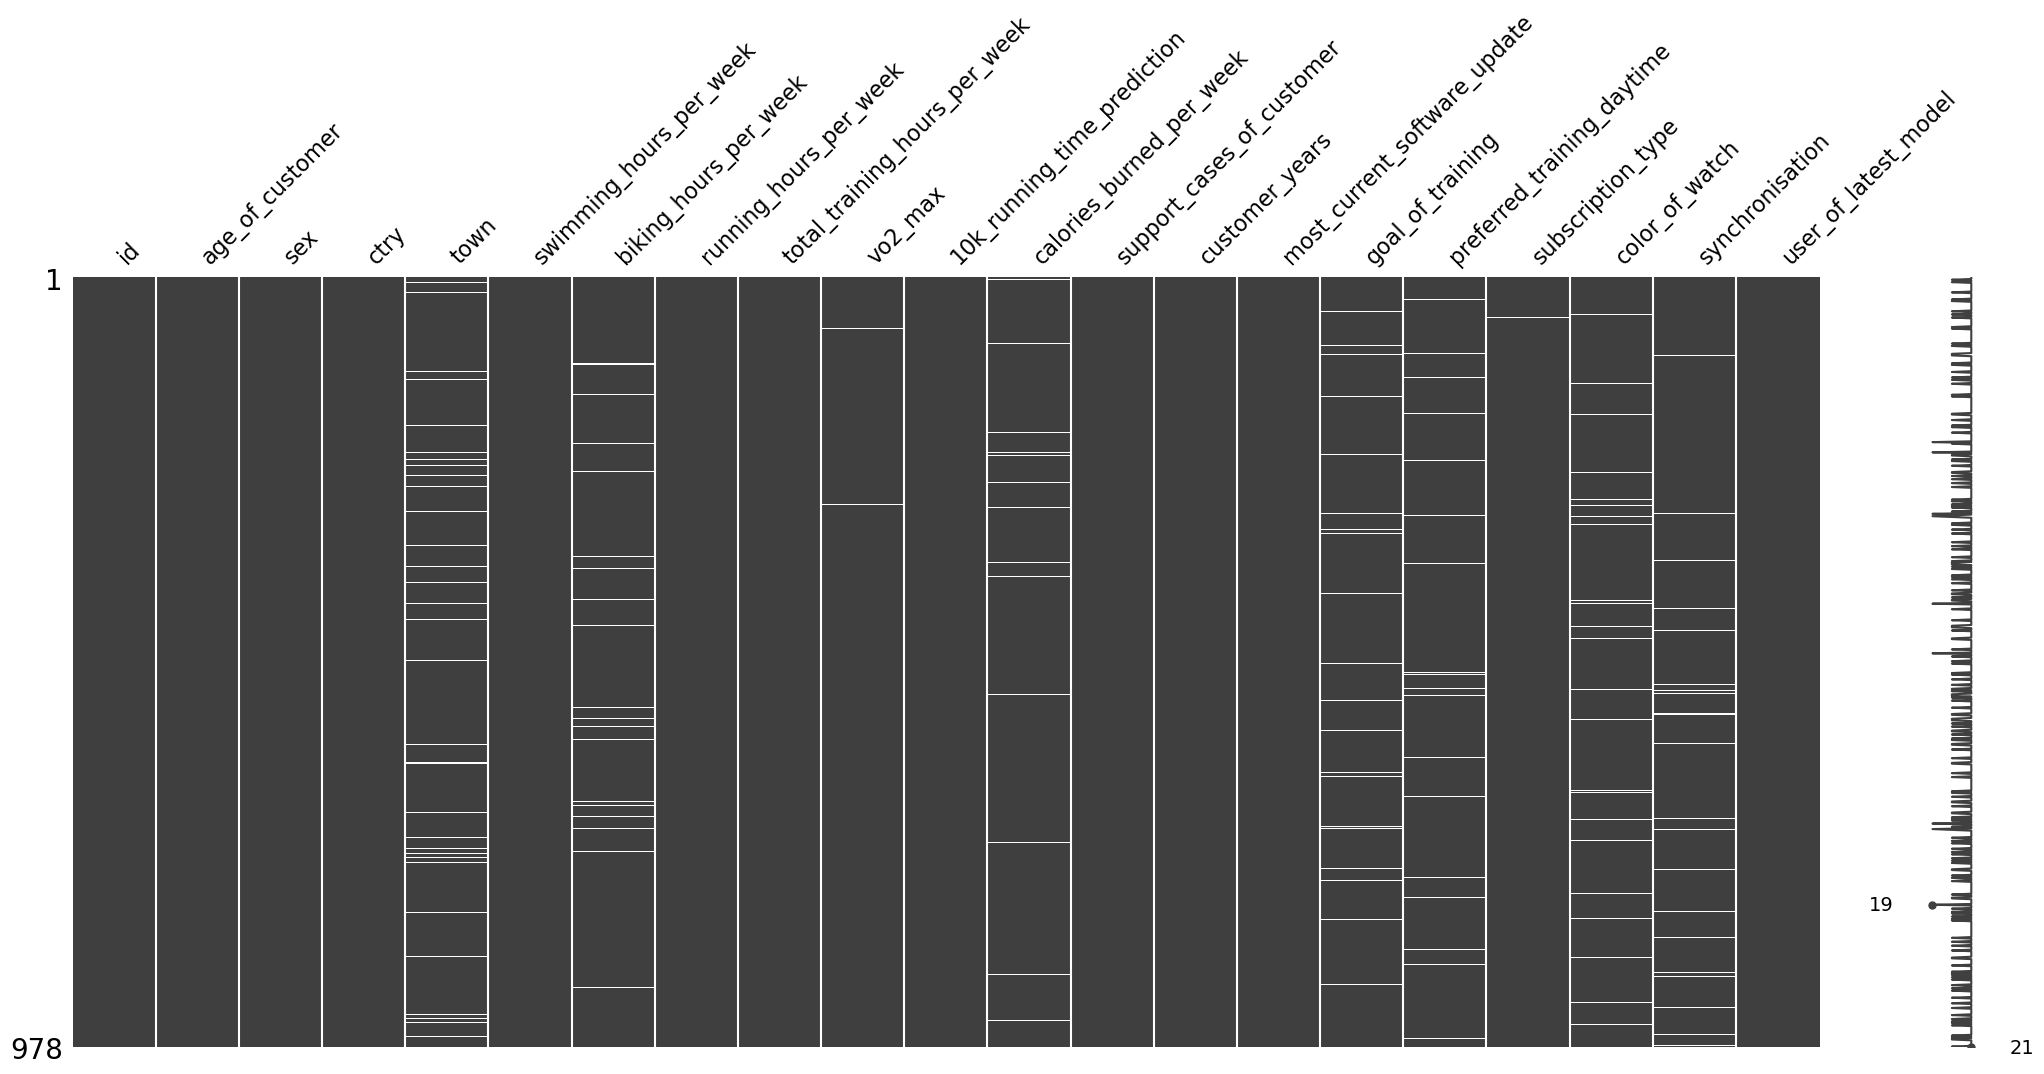

In [15]:
# Missing Value Handling - Deletion of entries with missing values in the target colunm
df=df.drop(df[df[target_columns[0]].isnull()].index)
msno.matrix(df)

<Axes: >

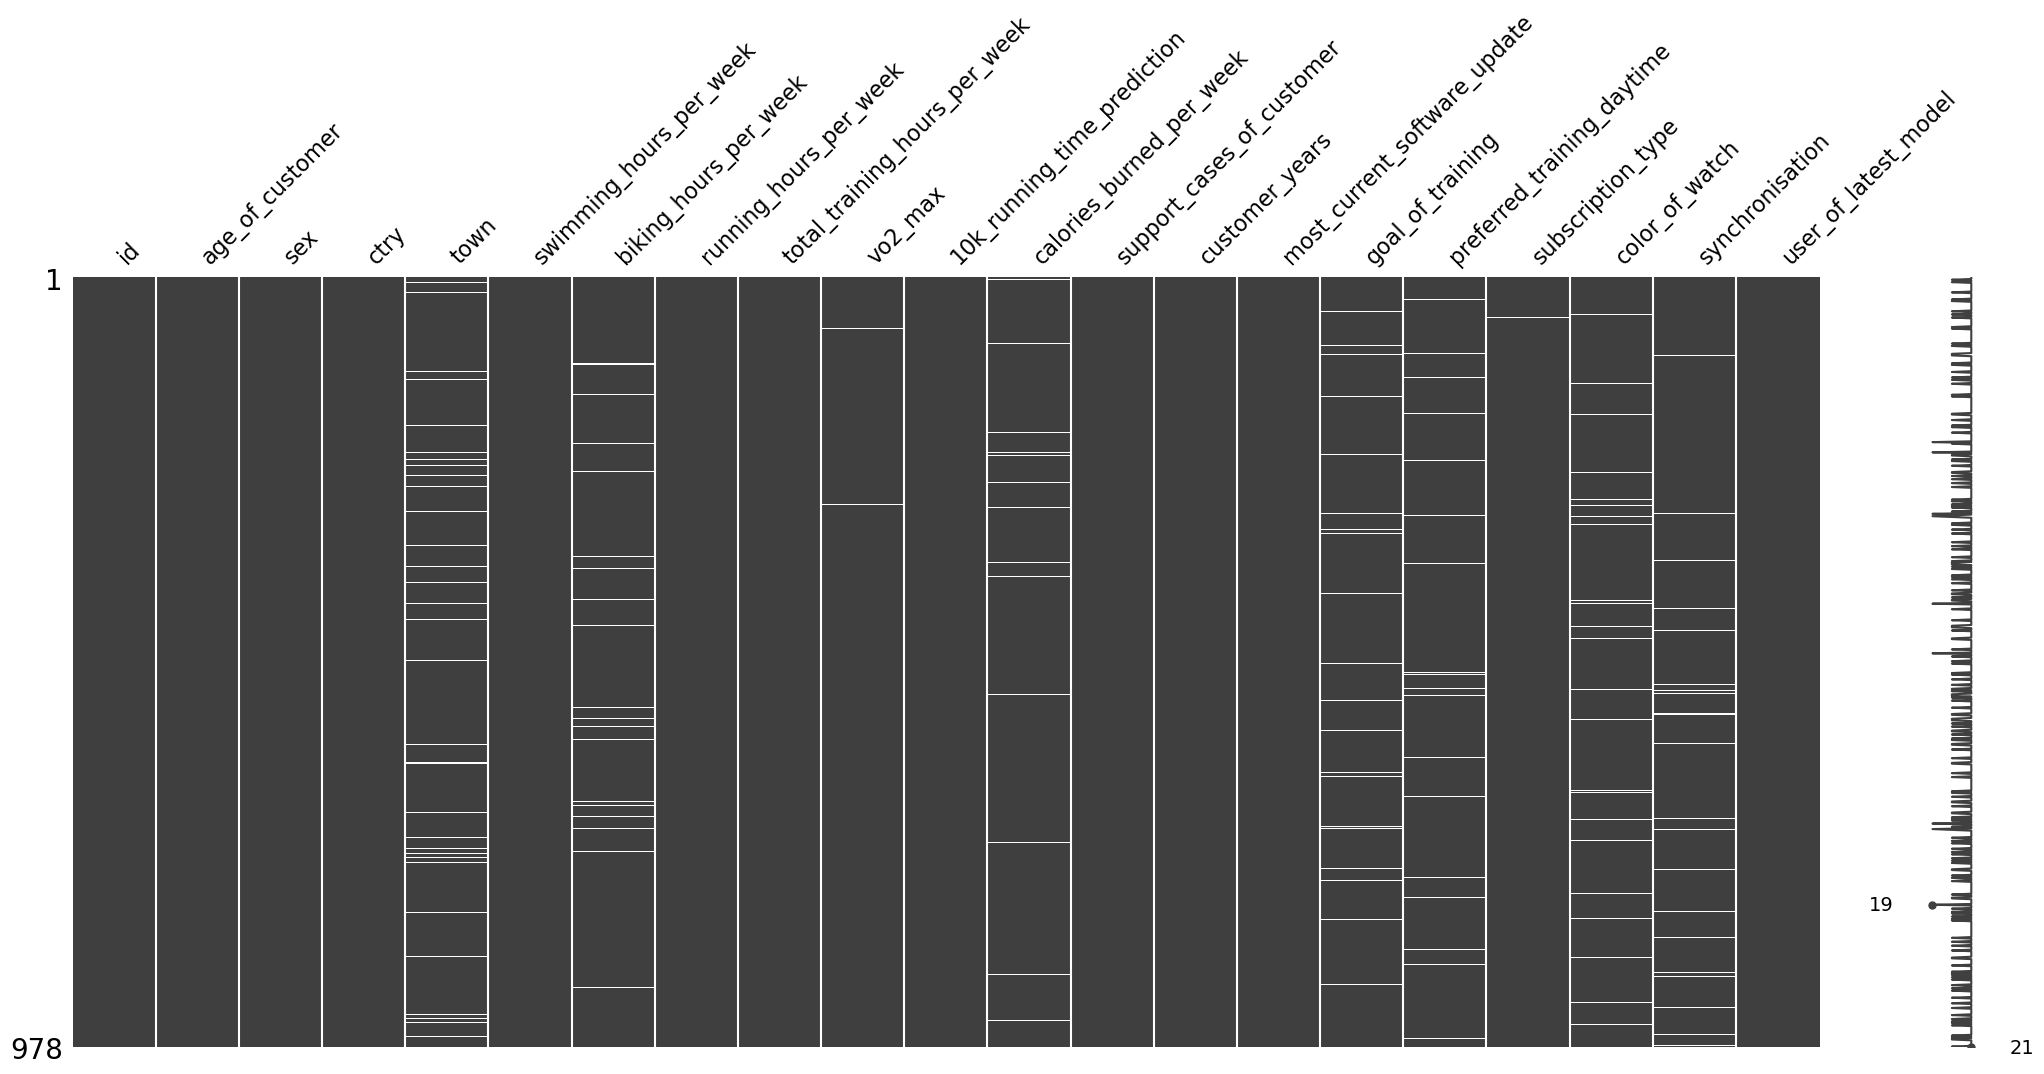

In [16]:
#Listwise deletion (all rows with multiple missing values)
df=df.drop(df[df.isnull().sum(axis=1)>2].index)
msno.matrix(df)

### Impute values for numerical columns

1) Use median imputation for Outliers. 
2) Use mean imputation for missing values after cleaning outliers. 

In [17]:
## Identify outliers with IQR methods and replace them with the median 
for col in numeric_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = (df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))
    df[col] = df[col].mask(outliers, np.nan)
    df[col] = df[col].fillna(df[col].median())

In [18]:
# Impute missing values in numeric columns with mean
for col in numeric_columns:
    df[col] = df[col].fillna(df[col].mean())

### Behandlung der Kategorischen Missing Values

In [20]:
category_columns

['sex',
 'ctry',
 'town',
 'goal_of_training',
 'preferred_training_daytime',
 'subscription_type',
 'color_of_watch']

Die kategorischen Spalten `synchronisation`, `subscription_type`, `color_of_watch`, `subscription_type`, `preferred_training_daytime`, 'goal_of_training` und `town` enthalten fehlende Werte. Um den Bias (Verzerrung) so gering wie möglich zu halten, gibt es mehrere Ansätze zur Imputation der fehlenden Werte für kategorische Spalten:

**Verwendung des Modus (Häufigster Wert)**:
    - Funktionsweise: Ersetzt fehlende Werte durch die am häufigsten vorkommende Kategorie in der Spalte.
    - Vorteile: Einfach und rechnerisch effizient.
    - Nachteile: Kann zu Verzerrungen führen, wenn die häufigste Kategorie überrepräsentiert ist.
    - Beste Anwendung: Wenn die Spalte eine klar dominante Kategorie hat.

**Zufällige Imputation aus vorhandenen Kategorien**
    - Funktionsweise: Weist zufällig einen Wert aus den vorhandenen Kategorien zu (gewichtet nach ihrer Verteilung).
    - Vorteile: Bewahrt die ursprüngliche Verteilung und reduziert Verzerrungen.
    - Nachteile: Könnte Rauschen einführen, wenn die Daten zugrunde liegende Beziehungen haben.
    - Beste Anwendung: Wenn die Bewahrung der Kategorieproportionen wichtig ist.

**Prädiktive Imputation**
    - Funktionsweise: Verwendet ein maschinelles Lernmodell (z.B. logistische Regression, Entscheidungsbaum) um fehlende Werte basierend auf anderen Merkmalen vorherzusagen.
    - Vorteile: Berücksichtigt Beziehungen zu anderen Variablen, was die Genauigkeit potenziell verbessert.
    - Nachteile: Rechenintensiv und kann überanpassen, besonders bei kleinen Datensätzen.
    - Beste Anwendung: Wenn andere Merkmale starke Signale für die fehlenden Werte liefern.

**K-Nächste-Nachbarn (KNN) Imputation**
    - Funktionsweise: Weist die häufigste Kategorie unter den k-nächsten Nachbarn zu (basierend auf Merkmalsähnlichkeit).
    - Vorteile: Bewahrt lokale Muster in den Daten.
    - Nachteile: Rechenintensiv und empfindlich gegenüber Distanzmetriken.
    - Beste Anwendung: Wenn die Daten Cluster oder lokale Strukturen aufweisen.

**Eigene Kategorie für fehlende Werte**
    - Funktionsweise: Erstellt eine neue Kategorie, wie "Unbekannt" oder "Fehlend".
    - Vorteile: Hält die fehlenden Werte identifizierbar und vermeidet Annahmen.
    - Nachteile: Kann eine neue, potenziell nicht-informative Kategorie einführen, die Modelle beeinflussen könnte.
    - Beste Anwendung: Wenn fehlende Werte bedeutungsvoll sind (z.B. wenn sie einen Mangel an Informationen anzeigen).

Daher werden wir einen Schwellenwert definieren, sodass wir bei weniger als 5% fehlenden Werten die Modus-Kategorie imputieren. Andernfalls verwenden wir die prädiktive Imputation basierend auf dem Anova-Test.

In [22]:
#Dieser Code führt Chi-Quadrat-Tests für alle möglichen Kombinationen von Spalten durch, um 
# Abhängigkeiten zwischen kategorischen Variablen zu identifizieren. 
# Zuerst werden alle relevanten Spalten in einer Liste columns zusammengefasst, die aus: Kategorischen Spalten (category_columns)
# Booleschen Spalten (bool_columns), Text-Spalten (text_columns), Zielvariablen (target_columns)
#Erstellt eine leere DataFrame-Matrix mit den Spaltennamen als sowohl Zeilen- als auch Spaltenindex 
# Für jede Kombination: df_chi2 = df[[i,j]]: Extrahiert die zwei zu vergleichenden Spalten, data_cont=pd.crosstab(): 
# Erstellt eine Kontingenztabelle der beiden Variablen, chi2_contingency(): Führt den Chi-Quadrat-Test durch und gibt zurück:
# tat: Chi-Quadrat-Statistik, p: p-Wert, dof: Freiheitsgrade, expected: Erwartete Häufigkeiten, from scipy.stats import 
# chi2_contingency columns = category_columns + bool_columns + text_columns + target_columns
# Der p-Wert wird in der Ergebnis-Matrix gespeichert: chi2_values.loc[i,j] = p Der Code hilft dabei, statistisch 
# signifikante Zusammenhänge zwischen den Variablen zu identifizieren: Kleine p-Werte (< 0.05) deuten auf signifikante 
# Abhängigkeiten hin, Große p-Werte weisen auf Unabhängigkeit der Variablen hin, Dies ist besonders nützlich für:
# Feature Selection, Verständnis von Variablenbeziehungen, Identifikation redundanter Informationen im Datensatz

# perform chi-squared test for nominal features
from scipy.stats import chi2_contingency

columns = category_columns + bool_columns + text_columns + target_columns
#create a new dataframe which contains chi2 values for all feature combinations
chi2_values = pd.DataFrame(index=columns, columns=columns)
for i in columns:
    for j in columns:
        df_chi2 = df[[i,j]]
        data_cont=pd.crosstab(df_chi2.iloc[:,0], df_chi2.iloc[:,1])
        stat, p, dof, expected = chi2_contingency(data_cont)
        chi2_values.loc[i,j] = p

<Axes: >

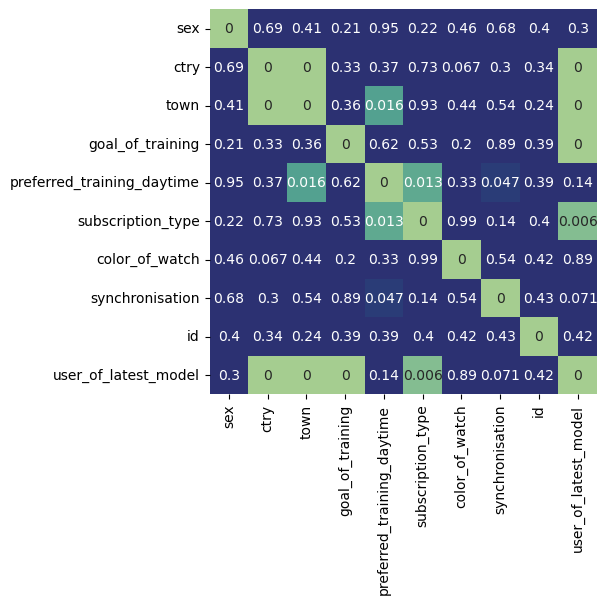

In [23]:
#display chi2 p-values as a color coded heatmap with a threshold of 0.05, round p-values to 2 digits
plt.figure(figsize=(5,5))
sns.heatmap(round(chi2_values.astype(float),3), annot=True, cmap='crest', cbar=False, vmin=0, vmax=0.05)

Starke Zusammenhänge (p-Wert < 0.05) finden sich zwischen:

**preferred_training_daytime** und: 
 * Town (p = 0.016) 
 * subscription_type (p = 0.013)

**subscription_type** und:
* user_of_latest_model (p = 0.006)

Relativ unabhängige Variablen (hohe p-Werte > 0.5) sind beispielsweise:
color_of_watch und subscription_type (p = 0.99)
synchronisation und goal_of_training (p = 0.89)
color_of_watch und user_of_latest_model (p = 0.89)

In [24]:
# Missing values in percentage
_df_category = df[category_columns]
prc_missing_values = _df_category.isna().sum()/len(df)*100

print("Percentage of missing values per columns")
print(prc_missing_values)
print()

Percentage of missing values per columns
sex                           0.000000
ctry                          0.000000
town                          3.987730
goal_of_training              2.862986
preferred_training_daytime    2.453988
subscription_type             0.102249
color_of_watch                3.271984
dtype: float64



Dieser Code behandelt fehlende Werte in einem DataFrame basierend auf einem prozentualen Schwellenwert:

1. `for col in prc_missing_values.index`:
   - Durchläuft alle Spalten, die in prc_missing_values indiziert sind
   - prc_missing_values enthält vermutlich die prozentualen Anteile der fehlenden Werte pro Spalte

2. `if prc_missing_values[col] > 0 and prc_missing_values[col] <= 5`:
   - Prüft, ob der Prozentsatz der fehlenden Werte:
     - größer als 0% ist (es gibt überhaupt fehlende Werte)
     - kleiner oder gleich 5% ist (nicht zu viele fehlende Werte)

3. Wenn diese Bedingung erfüllt ist:
   - `print("Impute missing values in column: ", col, " with mode")`: 
     Gibt eine Nachricht aus, welche Spalte gerade bearbeitet wird
   - `df[col].mode()[0]`: Berechnet den Modus (häufigster Wert) der Spalte
   - `df[col].fillna()`: Ersetzt alle fehlenden Werte (NA/NaN) mit diesem Modus-Wert

Dies ist eine konservative Strategie zur Behandlung fehlender Werte:
- Nur Spalten mit relativ wenigen fehlenden Werten (≤ 5%) werden auf diese Weise behandelt
- Der häufigste Wert wird als Ersatz verwendet
- Spalten mit mehr als 5% fehlenden Werten werden nicht bearbeitet (diese erfordern möglicherweise andere Strategien)



In [25]:
for col in prc_missing_values.index:
    if prc_missing_values[col] > 0 and prc_missing_values[col] <= 5:
        print("Impute missing values in column: ", col, " with mode")
        df[col] = df[col].fillna(df[col].mode()[0])

Impute missing values in column:  town  with mode
Impute missing values in column:  goal_of_training  with mode
Impute missing values in column:  preferred_training_daytime  with mode
Impute missing values in column:  subscription_type  with mode
Impute missing values in column:  color_of_watch  with mode


In [ ]:
msno.matrix(df)

Basierend auf der vorherigen Chi-Quadrat-Analyse können wir die Variable `preferred_training_daytime` als Prädiktor für die Variable `synchronisation` verwenden, da der p-Wert kleiner als 0.05 ist. Dafür transformieren wir die kategorischen Werte der Prädiktor-Spalten in One-Hot-kodierte Werte und verwenden ein logistisches Regressionsmodell.

Das bedeutet konkret:
- Die Beziehung zwischen `preferred_training_daytime` und `synchronisation` ist statistisch signifikant
- Die kategorischen Werte werden in binäre (0/1) Spalten umgewandelt (One-Hot-Encoding)
- Mit diesen transformierten Daten wird ein logistisches Regressionsmodell trainiert
- Dieses Modell kann dann verwendet werden, um fehlende Werte in `synchronisation` vorherzusagen

In [28]:
#Zuerst wird das Modell und die Datenstruktur vorbereitet:
#Importiert das LogisticRegression Modell
#Erstellt ein Dictionary, das definiert welche Spalte(n) als Prädiktor(en) für welche Zielvariable verwendet werden
from sklearn.linear_model import LogisticRegression
predective_model = {'synchronisation': ['preferred_training_daytime']}

#Die Hauptschleife:
#target ist die Zielspalte (hier: 'synchronisation')
#pred_cols sind die Prädiktorspalten (hier: ['preferred_training_daytime'])

for target, pred_cols in predective_model.items():
    print("Impute missing values in column: ", target, " with Logsitic Regression")
    # Vorbereitung der Trainingsdaten:
    # Erstellt einen temporären DataFrame mit nur den relevanten Spalten
    # Entfernt alle Zeilen mit fehlenden Werten (.dropna())
    _df = df[[target]+ pred_cols].dropna()
    #Datenaufbereitung für das Modell:
    # X: Konvertiert kategorische Prädiktoren in One-Hot-Encoding
    # y: Konvertiert die Zielvariable in boolean
    X, y = pd.get_dummies(_df[pred_cols], drop_first=True), _df[target].astype(bool)
    # Modelltraining: Erstellt und trainiert das logistische Regressionsmodell
    model = LogisticRegression()
    model.fit(X, y)
    # Vorhersage und Imputation: df[target].isnull(): Identifiziert fehlende Werte
    # model.predict(): Macht Vorhersagen für die fehlenden Werte
    # np.where(): Ersetzt nur die fehlenden Werte mit den Vorhersagen, behält existierende Werte bei
    df[target] = np.where(df[target].isnull(), model.predict(pd.get_dummies(df[pred_cols], drop_first=True)), df[target])

Impute missing values in column:  synchronisation  with Logsitic Regression


<Axes: >

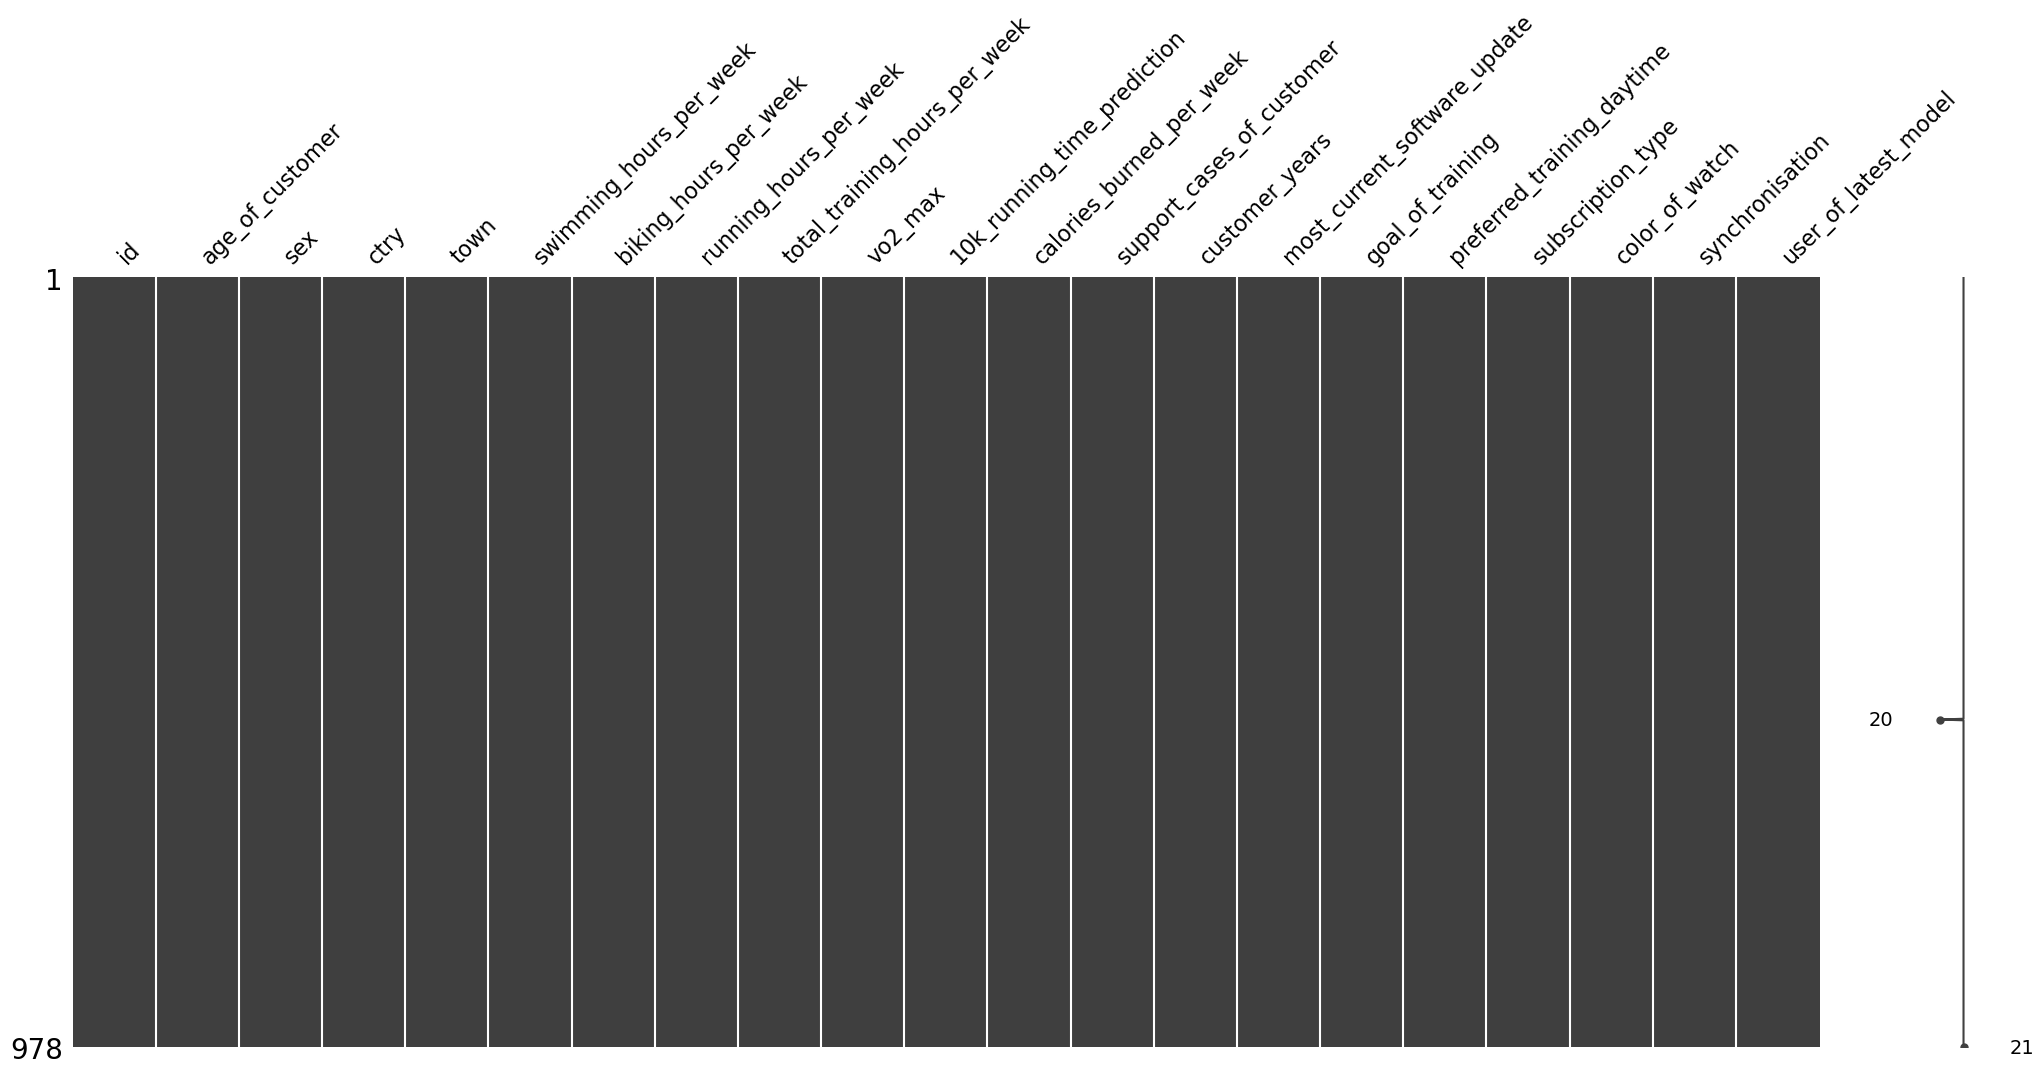

In [30]:
msno.matrix(df)

Folgender Code führt eine Normalitätsprüfung durch und transformiert nicht-normalverteilte Daten. 

1. Die `shapiro_wilk_test` Funktion:
```python
def shapiro_wilk_test(data, alpha):
```
- Führt den Shapiro-Wilk-Test durch, der prüft, ob Daten normalverteilt sind
- Gibt Test-Statistik und p-Wert zurück
- Wenn p > alpha (0.05): Daten sind normalverteilt
- Wenn p ≤ alpha: Daten sind nicht normalverteilt

2. Test aller numerischen Spalten:
```python
for col in numeric_columns:
    numeric_columns_gaussian_check[col] = shapiro_wilk_test(df[col],alpha)
```
- Testet jede numerische Spalte auf Normalverteilung
- Speichert das Ergebnis in einem Dictionary

3. Transformation nicht-normalverteilter Daten:
```python
for col in numeric_columns:
    if numeric_columns_gaussian_check[col] == False:
```
- Überprüft, welche Spalten nicht normalverteilt sind
- Für diese wird eine Quantilen-Transformation durchgeführt:
  - `n_quantiles = int(np.sqrt(len(df[col])))`: Berechnet die Anzahl der Quantile
  - `output_distribution='normal'`: Ziel ist eine Normalverteilung
  - `qt.fit_transform()`: Führt die Transformation durch
  - Speichert das Ergebnis in einer neuen Spalte mit Suffix '_transformed'

Der Code ist nützlich für:
- Überprüfung der Verteilungsform von Daten
- Transformation von Daten in eine Normalverteilung
- Vorbereitung von Daten für statistische Verfahren, die Normalverteilung voraussetzen

In [31]:
from scipy.stats import shapiro
from sklearn.preprocessing import QuantileTransformer

def shapiro_wilk_test(data,alpha):
    stat, p = shapiro(data)
    print('\tStatistics=%.3f, p=%.5f' % (stat, p))
    # interpret
    if p > alpha:
        print('\tSample looks Gaussian (fail to reject H0)')
        return True
    else:
        print('\tSample does not look Gaussian (reject H0)')
        return False

alpha = 0.05
numeric_columns_gaussian_check = {}
for col in numeric_columns:
    print("Normality test for column: ", col)
    numeric_columns_gaussian_check[col] = shapiro_wilk_test(df[col],alpha)    
    
# Quantile Transformation
for col in numeric_columns:
    if numeric_columns_gaussian_check[col] == False:
        print("Transforming column: ", col)
        n_quantiles = int(np.sqrt(len(df[col])))
        qt = QuantileTransformer(n_quantiles=n_quantiles, 
                                 output_distribution='normal',
                                 random_state=0)
        
        trans_x=qt.fit_transform(np.array(df[col].array.reshape(-1, 1)))
        df[f'{col}_transformed']=trans_x


Normality test for column:  age_of_customer
	Statistics=0.964, p=0.00000
	Sample does not look Gaussian (reject H0)
Normality test for column:  swimming_hours_per_week
	Statistics=0.964, p=0.00000
	Sample does not look Gaussian (reject H0)
Normality test for column:  biking_hours_per_week
	Statistics=0.972, p=0.00000
	Sample does not look Gaussian (reject H0)
Normality test for column:  running_hours_per_week
	Statistics=0.969, p=0.00000
	Sample does not look Gaussian (reject H0)
Normality test for column:  total_training_hours_per_week
	Statistics=0.977, p=0.00000
	Sample does not look Gaussian (reject H0)
Normality test for column:  vo2_max
	Statistics=0.941, p=0.00000
	Sample does not look Gaussian (reject H0)
Normality test for column:  10k_running_time_prediction
	Statistics=0.961, p=0.00000
	Sample does not look Gaussian (reject H0)
Normality test for column:  calories_burned_per_week
	Statistics=0.981, p=0.00000
	Sample does not look Gaussian (reject H0)
Normality test for colum

Dieser Code erstellt Histogramme für alle transformierten numerischen Spalten:

1. `transformed_num_columns = [col for col in df.columns if 'transformed' in col]`:
   - Erstellt eine Liste aller Spaltennamen, die das Wort 'transformed' enthalten
   - Also alle Spalten, die vorher mit der Quantilen-Transformation bearbeitet wurden

2. `df.filter(transformed_num_columns).hist(figsize=(10,10))`:
   - `filter()`: Wählt nur die transformierten Spalten aus
   - `hist()`: Erstellt für jede dieser Spalten ein Histogramm
   - `figsize=(10,10)`: Setzt die Größe der gesamten Grafik auf 10x10 Zoll

Der Zweck ist:
- Visuelle Überprüfung, ob die Transformation erfolgreich war
- Die Histogramme sollten nun annähernd eine Glockenkurve (Normalverteilung) zeigen
- Vergleich der Verteilungen der verschiedenen transformierten Variablen
- Qualitätskontrolle der Datentransformation

Dies ist ein wichtiger Schritt in der explorativen Datenanalyse und der Vorbereitung von Daten für statistische Verfahren.

array([[<Axes: title={'center': 'age_of_customer_transformed'}>,
        <Axes: title={'center': 'swimming_hours_per_week_transformed'}>,
        <Axes: title={'center': 'biking_hours_per_week_transformed'}>],
       [<Axes: title={'center': 'running_hours_per_week_transformed'}>,
        <Axes: title={'center': 'total_training_hours_per_week_transformed'}>,
        <Axes: title={'center': 'vo2_max_transformed'}>],
       [<Axes: title={'center': '10k_running_time_prediction_transformed'}>,
        <Axes: title={'center': 'calories_burned_per_week_transformed'}>,
        <Axes: title={'center': 'support_cases_of_customer_transformed'}>],
       [<Axes: title={'center': 'customer_years_transformed'}>, <Axes: >,
        <Axes: >]], dtype=object)

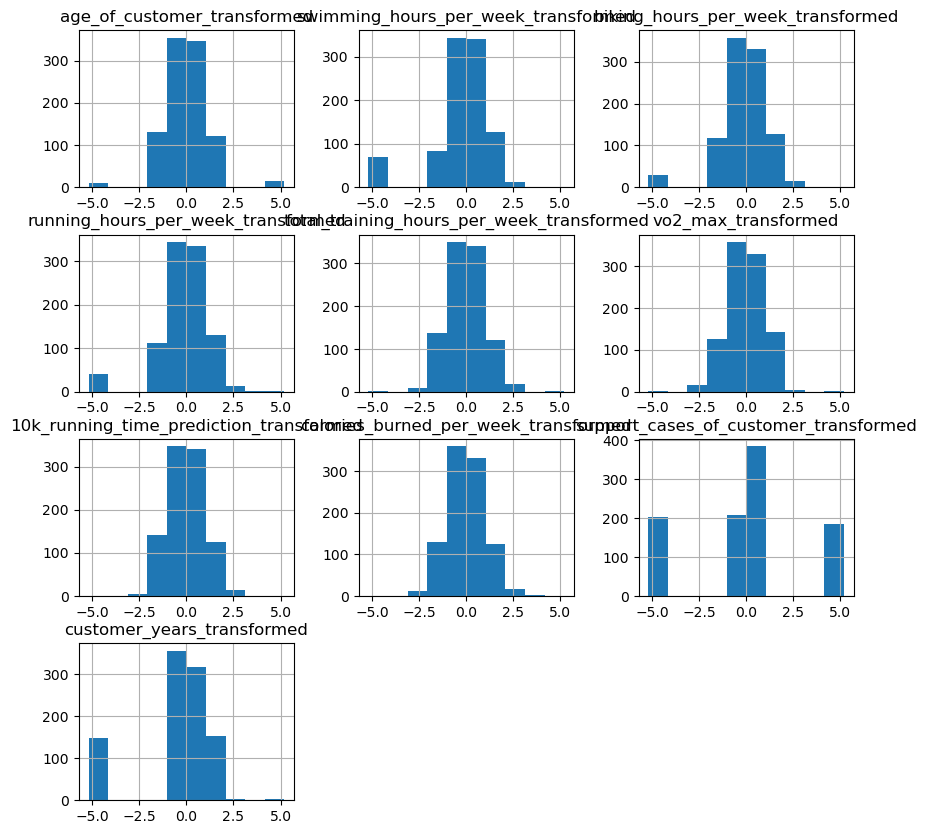

In [32]:
transformed_num_columns = [col for col in df.columns if 'transformed' in col]
df.filter(transformed_num_columns).hist(figsize=(10,10))

<Axes: >

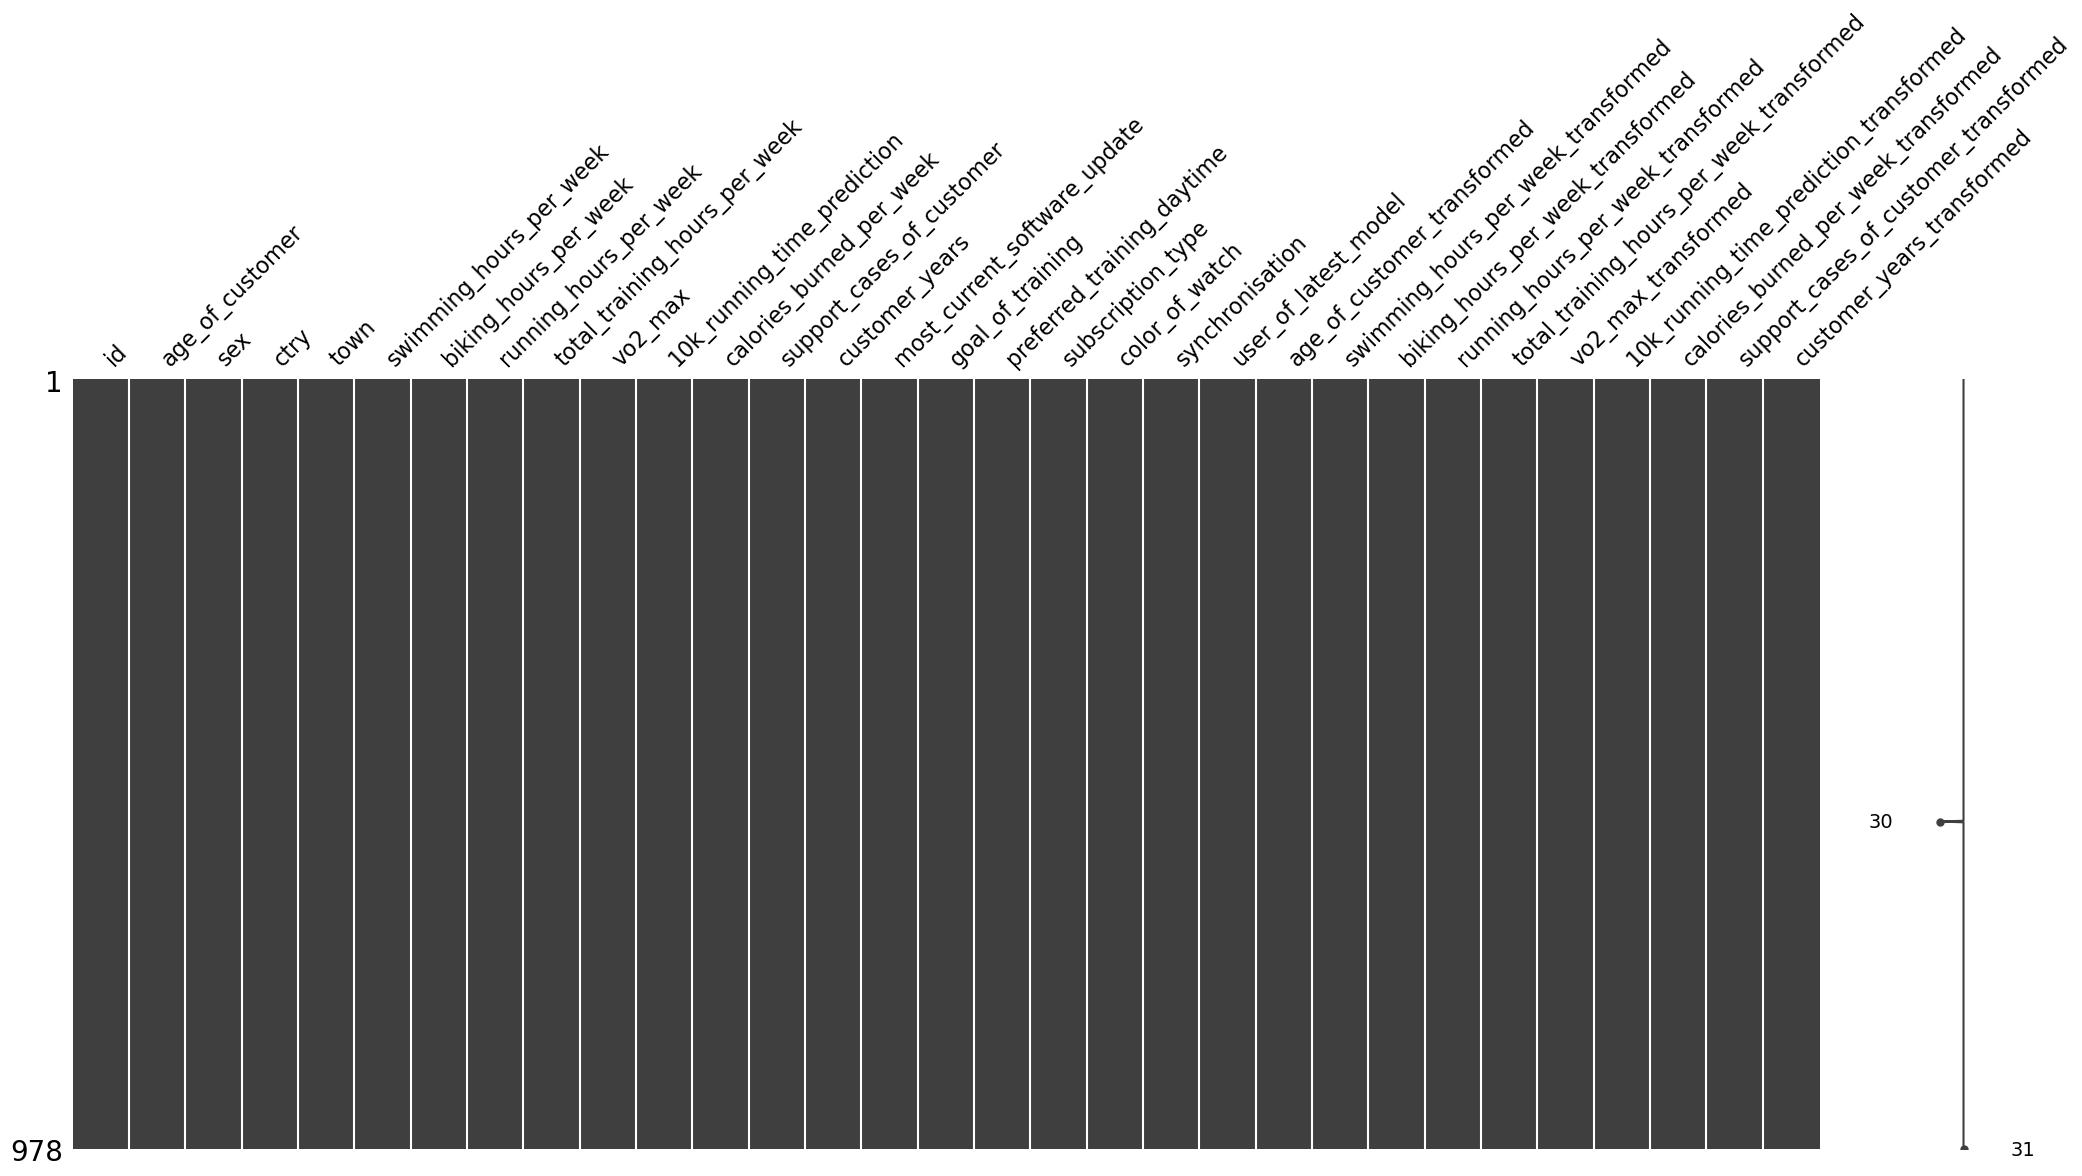

In [33]:
msno.matrix(df)

### Anwendung von One-Hot-Encoding für kategorische Spalten

Das One-Hot-Encoding ist eine Methode zur Umwandlung kategorischer Variablen in ein Format, das für maschinelle Lernalgorithmen geeignet ist:

- Jede Kategorie wird in eine eigene binäre Spalte (0 oder 1) umgewandelt
- Eine kategorische Variable mit n möglichen Werten wird zu n neuen binären Spalten
- Jede Zeile hat genau eine 1 und sonst nur 0en in diesen neuen Spalten

Beispiel:
Wenn eine Spalte "Farbe" die Werte "rot", "blau", "grün" enthält, entstehen drei neue Spalten:
- Farbe_rot: 1 wenn rot, sonst 0
- Farbe_blau: 1 wenn blau, sonst 0
- Farbe_grün: 1 wenn grün, sonst 0

Dies ist notwendig, da viele Machine Learning Algorithmen nicht direkt mit kategorischen Daten arbeiten können und numerische Eingaben benötigen.

Folgender Code führt ein One-Hot-Encoding durch und fügt die neuen Spalten zum ursprünglichen DataFrame hinzu:

1. `pd.get_dummies(df[category_columns], drop_first=True, prefix="hot_enc_")`:
   - Wendet One-Hot-Encoding auf alle kategorischen Spalten an
   - `drop_first=True`: Lässt die erste Kategorie weg (um Multikollinearität zu vermeiden)
   - `prefix="hot_enc_"`: Fügt allen neuen Spalten das Präfix "hot_enc_" hinzu
   - Das Ergebnis wird in `df_hot_encoded_feat` gespeichert

2. `pd.concat([df, df_hot_encoded_feat], axis=1)`:
   - Fügt die neuen One-Hot-Encoded Spalten zum ursprünglichen DataFrame hinzu
   - `axis=1` bedeutet, dass die Spalten horizontal aneinandergefügt werden
   - Weist das Ergebnis wieder dem ursprünglichen DataFrame `df` zu

Beispiel:
Wenn eine Spalte "Farbe" die Werte ["rot", "blau", "grün"] enthält:
- Die neuen Spalten würden heißen: "hot_enc_blau" und "hot_enc_grün"
- "hot_enc_rot" wird weggelassen (drop_first=True)
- Diese werden dann rechts an den ursprünglichen DataFrame angefügt

In [34]:
df_hot_encoded_feat = pd.get_dummies(df[category_columns], drop_first=True, prefix="hot_enc_")
df = pd.concat([df, df_hot_encoded_feat], axis=1)

Dieser Code erstellt eine Liste aller Features, die für das Modell verwendet werden sollen, und zeigt sie an:

1. `model_features = transformed_num_columns + list(df_hot_encoded_feat.columns)`:
   - Kombiniert zwei Listen von Spaltennamen:
     - `transformed_num_columns`: Die transformierten numerischen Spalten
     - `list(df_hot_encoded_feat.columns)`: Die One-Hot-Encoded kategorischen Spalten

2. `print(np.array(model_features))`:
   - Konvertiert die Liste in ein NumPy-Array
   - Gibt alle Feature-Namen aus, die im Modell verwendet werden sollen

Dies ist ein wichtiger Schritt in der Modellvorbereitung, da er:
- Alle relevanten Features zusammenfasst
- Eine Übersicht der Eingabevariablen für das Modell gibt
- Sicherstellt, dass sowohl die transformierten numerischen als auch die One-Hot-Encoded kategorischen Variablen berücksichtigt werden

In [35]:
model_feateures = transformed_num_columns + list(df_hot_encoded_feat.columns)
print(np.array(model_feateures))

['age_of_customer_transformed' 'swimming_hours_per_week_transformed'
 'biking_hours_per_week_transformed' 'running_hours_per_week_transformed'
 'total_training_hours_per_week_transformed' 'vo2_max_transformed'
 '10k_running_time_prediction_transformed'
 'calories_burned_per_week_transformed'
 'support_cases_of_customer_transformed' 'customer_years_transformed'
 'hot_enc__Male' 'hot_enc__Other' 'hot_enc__Germany' 'hot_enc__India'
 'hot_enc__UK' 'hot_enc__USA' 'hot_enc__UnknownLand' 'hot_enc__Berlin'
 'hot_enc__Birmingham' 'hot_enc__Brisbane' 'hot_enc__Chicago'
 'hot_enc__Delhi' 'hot_enc__Hamburg' 'hot_enc__London'
 'hot_enc__Los Angeles' 'hot_enc__Manchester' 'hot_enc__Melbourne'
 'hot_enc__Mumbai' 'hot_enc__Munich' 'hot_enc__New York' 'hot_enc__Sydney'
 'hot_enc__Fitness' 'hot_enc__Recreation' 'hot_enc__Evening'
 'hot_enc__Morning' 'hot_enc__Free' 'hot_enc__Premium' 'hot_enc__White']


<Axes: >

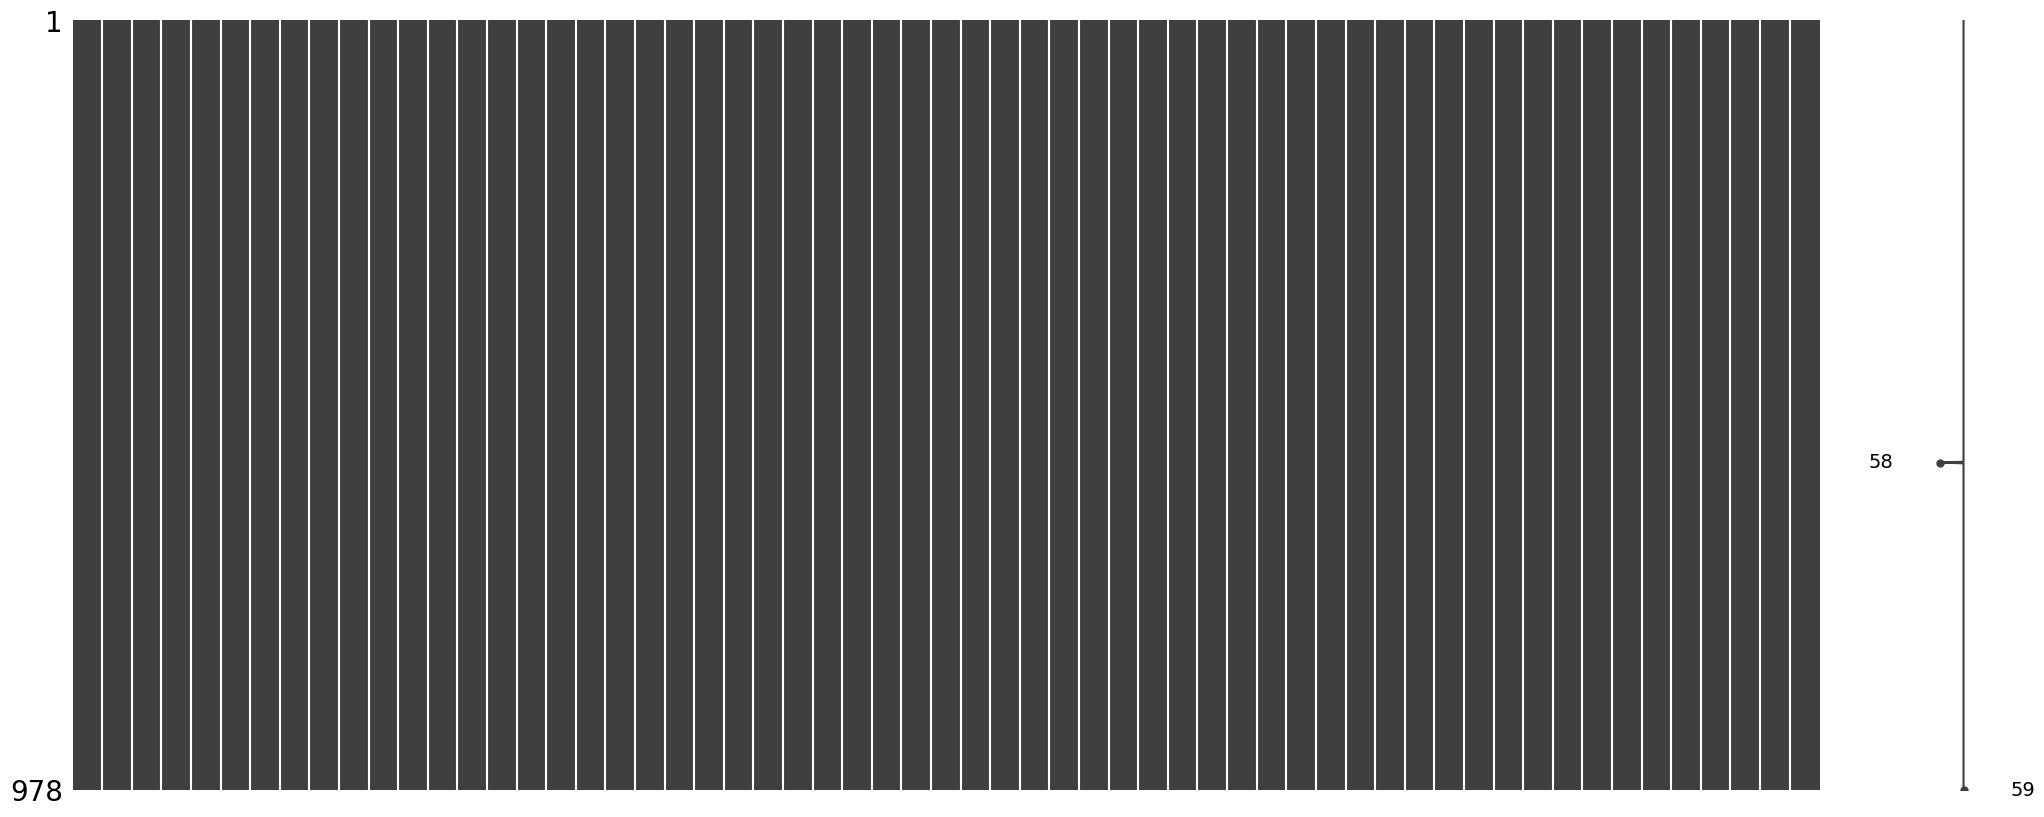

In [36]:
msno.matrix(df)

## Feature Selection

Nachfolgendes Tool generiert eine HTML, die einen umfangreichen Überblick über alle Variablen gibt

In [ ]:
#!pip install ydata_profiling

In [ ]:
# from ydata_profiling import ProfileReport
# df = pd.read_csv("../../data/raw/triathlon_watch_training_data_final.csv")
# profile = ProfileReport(df, title="Profiling Report")
# profile.to_file("EDA_Report.html")